In [1]:
import datetime
today = datetime.date.today()
datestr = today.strftime('%m-%d 00:00 현재')
print(f'데이터 분석시점: {datestr}')

데이터 분석시점: 04-18 00:00 현재


# 코로나바이러스감염증-19 감염현황 데이터 일일 분석

질병관리본부에서 매일 발표하고 있는 일일 집계 현황을 다음의 구글 시트에 별도로 저장한 후, 이를 분석합니다.

https://docs.google.com/spreadsheets/d/1nqc9A9M5QJgSnjkErWeyDS4KTiLB1N9VjHd3T6k69hE/

활용 가능한 데이터가 추가되는대로 계속 보완합니다. 

In [2]:
%matplotlib inline

from io import BytesIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import requests

matplotlib 차트 한글폰트 설정

In [3]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

구글시트에 정리된 데이터를 가져옵니다.

In [4]:
r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1nqc9A9M5QJgSnjkErWeyDS4KTiLB1N9VjHd3T6k69hE&output=csv')
df = pd.read_csv(BytesIO(r.content), index_col=0, skiprows=1).iloc[2:, :-4]
df.columns = [c.replace('\n', ' ') for c in df.columns]
df.index = pd.to_datetime([f'2020-{i}' for i in df.index])

for comma_str in ('대구', '경북', '확진자', '검사수', '격리  해제'):
    df[comma_str] = df[comma_str].str.replace(',', '').astype(float)

df = df.replace(np.nan, 0).sort_index()

In [5]:
df.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,경북,경남,제주,검역,지역 모름,확진자,사망,격리 해제,검사수,양성 비율(%)
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,22.0,4.55
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,25.0,4.00
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,48.0,2.08
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,57.0,1.75


In [6]:
regions = [
    '서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', 
    '충북', '충남', '전북', '전남', '경북', '경남', '제주', '검역',
]

누적값을 별도 컬럼에 추가합니다.

In [7]:
for c in df.columns:
    df[f'{c} 누적'] = df[c].cumsum()

df.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,경북 누적,경남 누적,제주 누적,검역 누적,지역 모름 누적,확진자 누적,사망 누적,격리 해제 누적,검사수 누적,양성 비율(%) 누적
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,22.0,4.55
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,47.0,8.55
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,47.0,8.55
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,95.0,10.63
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,152.0,12.38


누적 양성비율, 누적 사망율, 누적 대구경북 비율, 누적 완치율을 계산합니다. 확산 시작 직전으로 보이는 2월 18일 부터 표시합니다.

In [8]:
df['누적 양성비율'] = 100 * df['확진자 누적'] / df['검사수 누적']
df['누적 사망율'] = 100 * df['사망 누적'] / df['확진자 누적']
df['누적 대구경북 비율'] = 100 * (df['대구 누적'] + df['경북 누적']) / df['확진자 누적']
df['누적 완치율'] = 100 * df['격리  해제 누적'] / df['확진자 누적']
df['누적 수도권'] = df['서울 누적'] + df['경기 누적'] + df['인천 누적']
df['누적 수도권 비율'] = 100 * df['누적 수도권'] / df['확진자 누적']
df = df.loc['2020-02-18':]

일일 현황을 차트로 표시합니다.

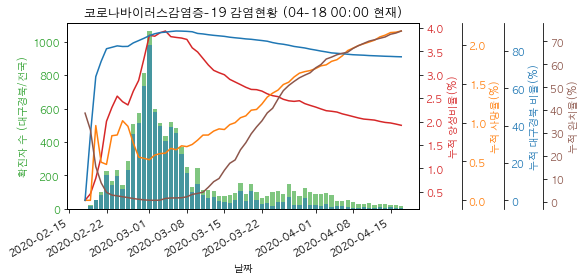

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:green'
ax1.set_xlabel('날짜')
ax1.set_ylabel('확진자 수 (대구경북/전국)', color=color)
#ax1.set_ylim(0, 1000)
plt.bar(x=df.index, height=df['확진자'], color=color, alpha=0.6)
plt.bar(x=df.index, height=df['대구']+df['경북'], color="tab:blue", alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('누적 양성비율(%)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['누적 양성비율'], color=color)
#ax2.set_ylim(0., 4.5)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:orange'
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.12))
ax3.set_ylabel('누적 사망율(%)', color=color)  # we already handled the x-label with ax1
ax3.plot(df['누적 사망율'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.24))
ax4.set_ylabel('누적 대구경북 비율(%)', color=color)  # we already handled the x-label with ax1
ax4.plot(df['누적 대구경북 비율'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

color = 'tab:brown'
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("axes", 1.35))
ax5.set_ylabel('누적 완치율(%)', color=color)  # we already handled the x-label with ax1
ax5.plot(df['누적 완치율'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

#plt.xticks(rotation=90)
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'코로나바이러스감염증-19 감염현황 ({datestr})')

fig.tight_layout()
plt.show()

인구밀도 자료를 가져옵니다. http://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007 

In [10]:
density = pd.read_excel('data/stats_100701.xlsx', skiprows=2)
print(density.shape)
density.head()

(19, 9)


,Unnamed: 0,인구,인구밀도,인구.1,인구밀도.1,인구.2,인구밀도.2,인구.3,인구밀도.3
0,계,51015,509,51218,510,51362,512,51607,514
1,서울,9941,16425,9843,16263,9766,16136,9705,16034
2,부산,3452,4484,3447,4477,3424,4447,3400,4416
3,대구,2469,2794,2461,2786,2458,2782,2450,2773
4,인천,2883,2748,2907,2736,2924,2750,2939,2764


In [11]:
density.columns

Index(['Unnamed: 0', '인구', '인구밀도', '인구.1', '인구밀도.1', '인구.2', '인구밀도.2', '인구.3',
       '인구밀도.3'],
      dtype='object')

In [12]:
density.columns = ['지역', '2015-인구', '2015-인구밀도', '2016-인구', '2016-인구밀도', '2017-인구', '2017-인구밀도', 
                   '2018-인구', '2018-인구밀도']
density = density.iloc[1:, :].set_index('지역')
density = density.astype(float)
density.head()

,2015-인구,2015-인구밀도,2016-인구,2016-인구밀도,2017-인구,2017-인구밀도,2018-인구,2018-인구밀도
지역,,,,,,,,
서울,9941.0,16425.0,9843.0,16263.0,9766.0,16136.0,9705.0,16034.0
부산,3452.0,4484.0,3447.0,4477.0,3424.0,4447.0,3400.0,4416.0
대구,2469.0,2794.0,2461.0,2786.0,2458.0,2782.0,2450.0,2773.0
인천,2883.0,2748.0,2907.0,2736.0,2924.0,2750.0,2939.0,2764.0
광주,1506.0,3005.0,1502.0,2997.0,1495.0,2984.0,1493.0,2980.0


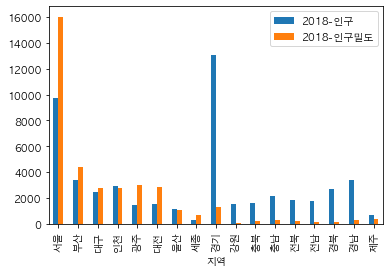

In [13]:
density.iloc[:-1, :][['2018-인구', '2018-인구밀도']].plot(kind='bar')

여러 차트를 종합하여 한장의 그림을 만듭니다. 가능한 한장의 차트에 모든 정보를 담을 수 있도록 노력합니다.

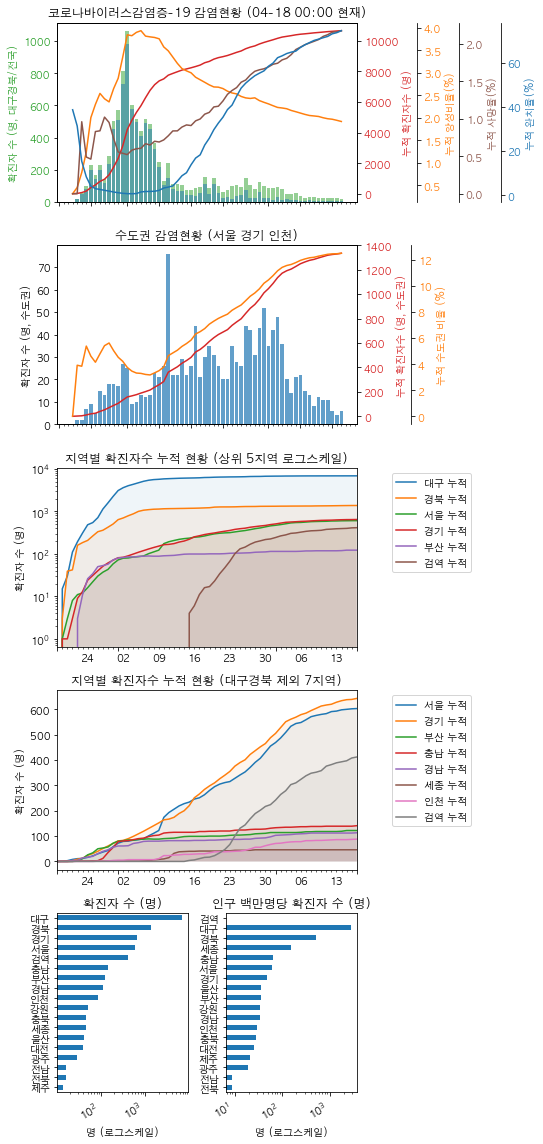

In [16]:
fig = plt.figure(figsize=(9, 16))

ax1 = fig.add_subplot(5, 1, 1)
color = 'tab:green'
ax1.set_ylabel('확진자 수 (명, 대구경북/전국)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title(f'코로나바이러스감염증-19 감염현황 ({datestr})')
ax1.xaxis.set_minor_locator(mdates.DayLocator())
plt.bar(x=df.index, height=df['확진자'], color=color, alpha=0.5)
plt.bar(x=df.index, height=df['대구']+df['경북'], color="tab:blue", alpha=0.5)

ax1_1 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax1_1.set_ylabel('누적 확진자수 (명)', color=color)  # we already handled the x-label with ax1
ax1_1.plot(df.index, df['확진자 누적'], color=color)
ax1_1.tick_params(axis='y', labelcolor=color)

ax1_2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax1_2.spines["right"].set_position(("axes", 1.20))
ax1_2.set_ylabel('누적 양성비율(%)', color=color)  # we already handled the x-label with ax1
ax1_2.plot(df.index, df['누적 양성비율'], color=color)
ax1_2.tick_params(axis='y', labelcolor=color)

ax1_3 = ax1.twinx()
color = 'tab:brown'
ax1_3.spines["right"].set_position(("axes", 1.34))
ax1_3.set_ylabel('누적 사망율(%)', color=color)  # we already handled the x-label with ax1
ax1_3.plot(df['누적 사망율'], color=color)
ax1_3.tick_params(axis='y', labelcolor=color)

ax1_4 = ax1.twinx()
color = 'tab:blue'
ax1_4.spines["right"].set_position(("axes", 1.48))
ax1_4.set_ylabel('누적 완치율(%)', color=color)  # we already handled the x-label with ax1
ax1_4.plot(df['누적 완치율'], color=color)
ax1_4.tick_params(axis='y', labelcolor=color)


ax2 = fig.add_subplot(5, 1, 2)
ax2.set_ylabel('확진자 수 (명, 수도권)')
ax2.set_title(f'수도권 감염현황 (서울 경기 인천)')
ax2.xaxis.set_minor_locator(mdates.DayLocator())
plt.bar(x=df.index, height=df['서울']+df['경기']+df['인천'], alpha=0.7)

ax2_1 = ax2.twinx()
color = 'tab:red'
ax2_1.set_ylabel('누적 확진자수 (명, 수도권)', color=color)  # we already handled the x-label with ax1
ax2_1.plot(df['누적 수도권'], color=color)
ax2_1.tick_params(axis='y', labelcolor=color)

ax2_2 = ax2.twinx()
color = 'tab:orange'
ax2_2.spines["right"].set_position(("axes", 1.18))
ax2_2.set_ylabel('누적 수도권 비율 (%)', color=color)  # we already handled the x-label with ax1
ax2_2.plot(df['누적 수도권 비율'] , color=color)
ax2_2.tick_params(axis='y', labelcolor=color)


ax3 = fig.add_subplot(5, 1, 3)
ax3.set_title('지역별 확진자수 누적 현황 (상위 5지역 로그스케일)')

for acu in ['대구 누적', '경북 누적', '서울 누적', '경기 누적', '부산 누적', '검역 누적']: #, '충남 누적', '경남 누적', '세종 누적', '인천 누적']:
    df[acu].plot(ax=ax3)
    ax3.fill_between(df.index, df[acu], alpha=0.07)

ax3.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax3.xaxis.set_minor_locator(mdates.DayLocator())
ax3.set_yscale('log')
ax3.set_ylabel('확진자 수 (명)')


ax4 = fig.add_subplot(5, 1, 4)
ax4.set_title('지역별 확진자수 누적 현황 (대구경북 제외 7지역)')

for acu in ['서울 누적', '경기 누적', '부산 누적', '충남 누적', '경남 누적', '세종 누적', '인천 누적', '검역 누적']:
    df[acu].plot(ax=ax4)
    ax4.fill_between(df.index, df[acu], alpha=0.07)

ax4.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax4.xaxis.set_minor_locator(mdates.DayLocator())
ax4.set_ylabel('확진자 수 (명)')


ax5_1 = fig.add_subplot(5, 2, 9)
ax5_1.set_title('확진자 수 (명)')
wotk = regions.copy()
df[wotk].sum().sort_values().plot(kind='barh', ax=ax5_1)
ax5_1.set_xscale('log')
ax5_1.set_xlabel('명 (로그스케일)')

ax5_2 = fig.add_subplot(5, 2, 10)
ax5_2.set_title('인구 백만명당 확진자 수 (명)')
confirm_density = df[regions].sum() * 1000 / density.loc[regions, '2018-인구']
confirm_density.sort_values().plot(kind='barh', ax=ax5_2)
ax5_2.set_xscale('log')
ax5_2.set_xlabel('명 (로그스케일)')


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(f'daily-chart/covid19-stat-{today.strftime("%m%d")}.png', dpi=200, format='png')

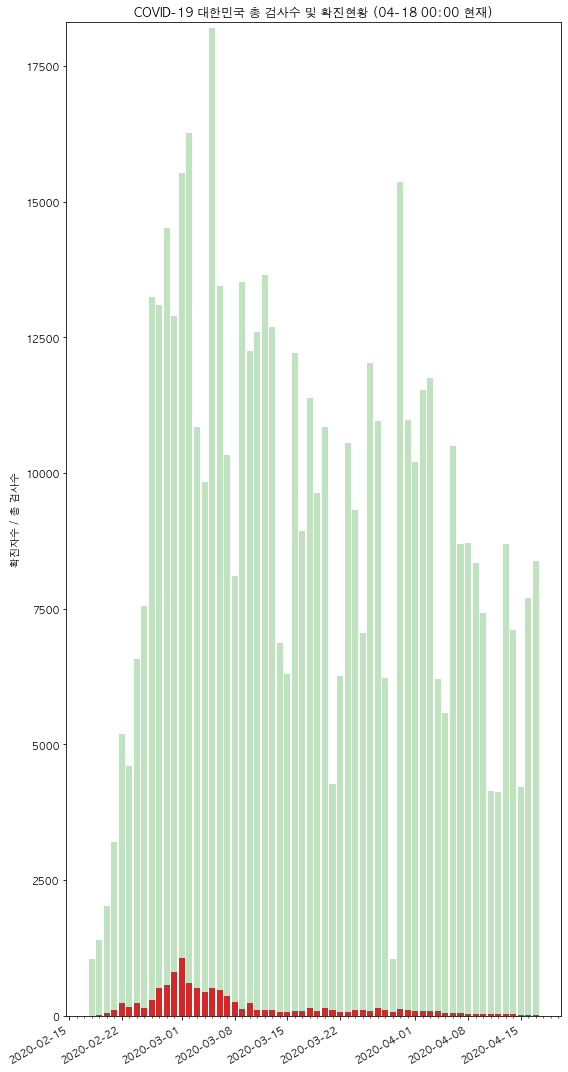

In [15]:
fig, ax1 = plt.subplots(figsize=(8, 15))
color = 'tab:green'
ax1.set_ylabel('확진자수 / 총 검사수')
ax1.set_title(f'COVID-19 대한민국 총 검사수 및 확진현황 ({datestr})')
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.set_ylim([0, 18300])
plt.bar(x=df.index, height=df['검사수'], color=color, alpha=0.3)
plt.bar(x=df.index, height=df['확진자'], color="tab:red")
plt.xticks(rotation=45)
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(f'daily-chart/covid19-stat-wtests-{today.strftime("%m%d")}.png', dpi=200, format='png')